In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import header
paths = header.setup_environment()
import platform
if platform.system()=='Darwin':
    INPUTDIR = '/Users/thompsong/Dropbox/PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602_Rocket_Seismology/DATA/2022_DATA/WellData/MERGED'
else:
    INPUTDIR = os.path.join(paths['new_data'], '03_merge_inventories')
import libWellData as LLE
transducersDF = LLE.get_transducers_dataframe(paths)
display(transducersDF)

# Load in the summary of all files - raw 4 hourly data 
dfall2 = pd.read_csv(os.path.join(INPUTDIR, 'all2.csv'))

def qc_dataframe(df):
    if 'TIMESTAMP' in df.columns:
        df['datetime'] = pd.to_datetime(df['TIMESTAMP'])
        df.drop(['TIMESTAMP', 'RECORD'], axis=1, inplace=True)
    df.dropna(how='all', axis=1, inplace=True) 
    df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

qc_dataframe(dfall2)

# Split in baro, 20Hz, 100Hz
all_dataframes = {}
for subdir in ['Baro', '20hz', '100hz']:
    dfsub = dfall2.copy()[dfall2['subdir']==subdir]
    qc_dataframe(dfsub)
    all_dataframes[subdir] = dfsub.copy()
    del dfsub

Linux


,serial,Fs,sensor,shielding,range_kPa_low,range_kPa_high,media,type,model,set_depth_ft,id,well,dig0,gf,tt,tt0,tf,bp,bp0
0,AirPressureShallow,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.81,6S.02374.88.HDH,shallow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1226420,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.46,6S.12264.20.HDD,shallow,9751.0,-0.006458,21.6,21.3,-0.008795,0.000,14.298
2,1226423,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-5.83,6S.12264.23.BDD,shallow,9605.0,-0.006347,21.6,22.2,-0.004197,14.504,14.298
3,1226419,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-6.71,6S.12264.19.HDD,shallow,10040.0,-0.006441,21.6,21.1,-0.010870,14.504,14.298
4,1226421,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-7.71,6S.12264.21.HDD,shallow,9787.0,-0.006724,21.6,21.3,-0.001145,14.504,14.298
5,AirPressureDeep,100,barometer,none,100,100,air,pressure,Keller 0507.01401.051311.07,3.86,6I.0XXXX.XX.HDH,intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1226429,100,vibrating_wire,none,70,170,air,level,Geokon 4500AL,4.11,6I.12264.29.HDD,intermediate,9800.0,-0.006428,22.6,21.6,-0.002384,0.000,14.298
7,2151692,20,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-9.14,6I.21516.92.BDD,intermediate,9459.0,-0.008038,22.8,21.8,0.007666,14.296,14.388
8,2151691,100,vibrating_wire,foam,70,170,water,level,Geokon 4500AL,-18.31,6I.21516.91.HDD,intermediate,9414.0,-0.008142,22.8,21.5,0.008742,14.296,14.388
9,2149882,100,vibrating_wire,none,70,170,water,level,Geokon 4500AL,-19.14,6I.21498.82.HDD,intermediate,9734.0,-0.008075,20.7,21.3,0.000675,14.602,14.389


In [2]:
# now let's pick a 24-hour period, and find all files from the all2.csv summary file within that time window, and plot them
dfday = dfall2.copy()

def trim(df, starttime, endtime):
    return df.query(f"datetime > {starttime.strftime('%Y%m%d%H%M%S')} & datetime < {endtime.strftime('%Y%m%d%H%M%S')}")

startt = '2022-11-01'
endt = '2022-11-02'
import glob
allcsvfiles = glob.glob(startt+'*.csv')
dfdata = {}
if len(allcsvfiles)>0:
    for csvfile in allcsvfiles:
        k = csvfile.split(f'{startt}_')[1].replace('.csv','')
        print(f'reading {csvfile} into dfdata[{k}]')
        dfdata[k] = pd.read_csv(csvfile, index_col=None)
else:
        
    dfday = trim(dfall2, starttime=pd.to_datetime(startt), endtime=pd.to_datetime(endt))
    
    # load and plot all these files
    for index, row in dfday.iterrows():
        subdir = row['subdir'].lower()
        fullpath = os.path.join(INPUTDIR, str(row['uploaddate']), row['subdir'], row['basename'])
        if not subdir in dfdata:
            dfdata[subdir] = pd.DataFrame()
        print(fullpath)
        if os.path.isfile(fullpath):
            print('- loading')
            thisdf = pd.read_csv(fullpath)
            qc_dataframe(thisdf)
            dfdata[subdir] = pd.concat([dfdata[subdir], thisdf])
            #display(dfdata[subdir])
        else:
            print('- not found')
    
    for k in dfdata.keys():
        csvfile = f'{startt}_{k}.csv'
        print(f'saving to {csvfile}')
        dfdata[k].to_csv(csvfile, index=None)

reading 2022-11-01_100hz.csv into dfdata[100hz]
reading 2022-11-01_baro.csv into dfdata[baro]
reading 2022-11-01_20hz.csv into dfdata[20hz]


In [3]:
print(dfdata)
for k in dfdata.keys():
    print(k)
    display(dfdata[k])

{'100hz':           1226421   1226419   1226420   2149882   2151691   1226429  \
0        9158.520  9477.936  9707.288  8620.012  8349.373  9778.442   
1        9158.551  9478.027  9707.175  8620.158  8349.221  9778.442   
2        9158.782  9477.992  9706.997  8620.499  8349.307  9778.987   
3        9158.424  9477.912  9707.313  8620.225  8349.430  9778.596   
4        9158.212  9478.027  9707.132  8620.443  8348.891  9778.425   
...           ...       ...       ...       ...       ...       ...   
7444945  9152.337  9471.828  9701.855  8615.547  8344.440  9771.317   
7444946  9153.037  9471.978  9701.472  8615.331  8344.303  9770.986   
7444947  9152.421  9472.357  9701.397  8615.638  8344.524  9771.357   
7444948  9152.700  9471.693  9701.688  8615.642  8344.434  9771.149   
7444949  9152.331  9471.912  9701.584  8615.442  8344.201  9771.284   

                        datetime  
0        2022-11-01 00:00:00.010  
1        2022-11-01 00:00:00.020  
2        2022-11-01 00:00:00.030

,1226421,1226419,1226420,2149882,2151691,1226429,datetime
0,9158.520,9477.936,9707.288,8620.012,8349.373,9778.442,2022-11-01 00:00:00.010
1,9158.551,9478.027,9707.175,8620.158,8349.221,9778.442,2022-11-01 00:00:00.020
2,9158.782,9477.992,9706.997,8620.499,8349.307,9778.987,2022-11-01 00:00:00.030
3,9158.424,9477.912,9707.313,8620.225,8349.430,9778.596,2022-11-01 00:00:00.040
4,9158.212,9478.027,9707.132,8620.443,8348.891,9778.425,2022-11-01 00:00:00.050
...,...,...,...,...,...,...,...
7444945,9152.337,9471.828,9701.855,8615.547,8344.440,9771.317,2022-11-01 23:59:59.960
7444946,9153.037,9471.978,9701.472,8615.331,8344.303,9770.986,2022-11-01 23:59:59.970
7444947,9152.421,9472.357,9701.397,8615.638,8344.524,9771.357,2022-11-01 23:59:59.980
7444948,9152.700,9471.693,9701.688,8615.642,8344.434,9771.149,2022-11-01 23:59:59.990


baro


,AirPressureShallow,AirPressureDeep,datetime
0,14.75795,14.75428,2022-11-01 00:00:00.010
1,14.75528,14.75397,2022-11-01 00:00:00.020
2,14.75952,14.75413,2022-11-01 00:00:00.030
3,14.75792,14.75290,2022-11-01 00:00:00.040
4,14.75926,14.75194,2022-11-01 00:00:00.050
...,...,...,...
7445709,14.80984,14.80734,2022-11-01 23:59:59.960
7445710,14.80875,14.80678,2022-11-01 23:59:59.970
7445711,14.81225,14.80987,2022-11-01 23:59:59.980
7445712,14.80950,14.80490,2022-11-01 23:59:59.990


20hz


,1226423,2151692,datetime
0,9069.992188,8421.872070,2022-11-01 00:00:00.050
1,9070.025391,8421.907227,2022-11-01 00:00:00.100
2,9070.023438,8421.853516,2022-11-01 00:00:00.150
3,9070.045898,8421.916016,2022-11-01 00:00:00.200
4,9069.985352,8421.887695,2022-11-01 00:00:00.250
...,...,...,...
1489060,9063.622070,8416.895508,2022-11-01 23:59:59.800
1489061,9063.609375,8416.880859,2022-11-01 23:59:59.850
1489062,9063.583984,8416.859375,2022-11-01 23:59:59.900
1489063,9063.556641,8416.869141,2022-11-01 23:59:59.950


,1226419,1226421,2151691,2149882
0,3.228309,3.835172,8.366177,8.690754
1,3.228309,3.835172,8.366177,8.690754
2,3.231812,3.838676,8.369681,8.694257
3,3.229298,3.836162,8.367167,8.691744
4,3.228199,3.835063,8.366068,8.690645
...,...,...,...,...
7444945,3.188950,3.796097,8.328520,8.653030
7444946,3.186822,3.793969,8.326392,8.650902
7444947,3.189207,3.796354,8.328777,8.653287
7444948,3.187870,3.795017,8.327440,8.651950


the estimated set_depth for sensor 1226419 is -2.26 m or -7.41 ft
the estimated set_depth for sensor 1226421 is -2.69 m or -8.81 ft
the estimated set_depth for sensor 2151691 is -5.87 m or -19.26 ft
the estimated set_depth for sensor 2149882 is -6.10 m or -20.01 ft


<Axes: xlabel='datetime', ylabel='Meters'>

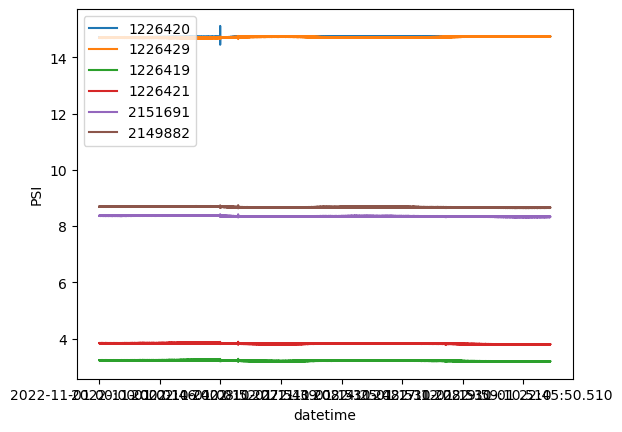

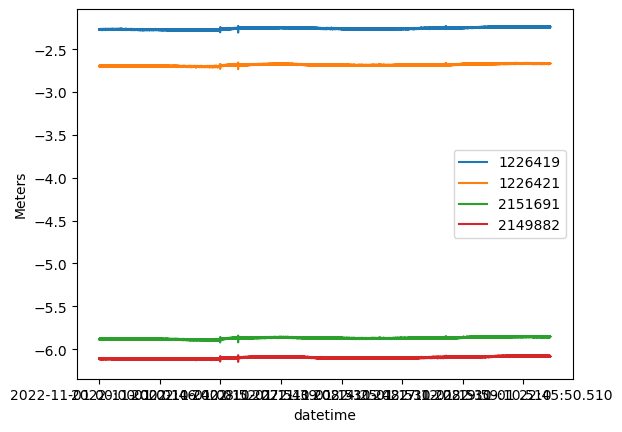

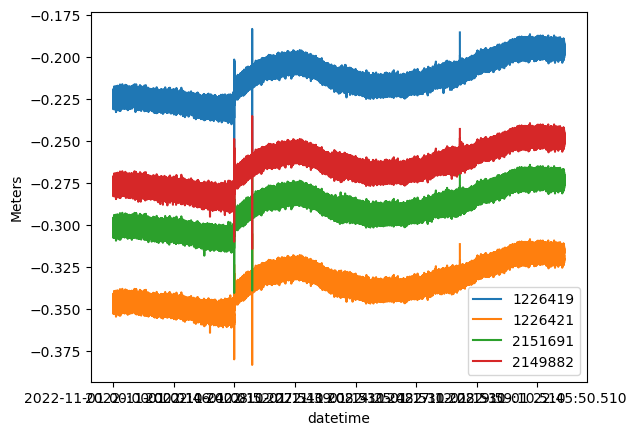

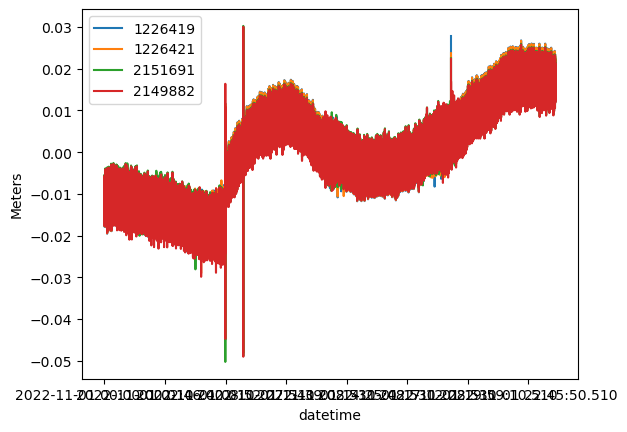

In [4]:
# 10.2: Correct analog and digital air column transducers for calibration, elevation above water, and apply DC shift (no temperature correction)
dcshifts2 = {'AirPressureShallow':0.0, 'AirPressureDeep':-0.003058, '1226420':-14.423795, '1226429':-14.556290}
aircolumns = ['AirPressureShallow', 'AirPressureDeep', '1226420', '1226429']
dfbaro_dcshifted = LLE.correctBarometricData(dfdata['baro'], aircolumns[:2], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)
df100hz_dcshifted = LLE.correctBarometricData(dfdata['100hz'], aircolumns[2:], transducersDF, temperatureCorrect=False, heightCorrect=True, dcshifts=dcshifts2)

# 10.4: Correct digital water column transducers for calibration and barometric pressure
correctedAllSensorsPSI = LLE.rawdf2psidf(df100hz_dcshifted, transducersDF, temperatureCorrect=False, airpressureCorrect=True, depthCorrect=False)
watercolumns = ['1226419', '1226421', '2151691', '2149882']
display(correctedAllSensorsPSI[watercolumns])

# 10.5: plot PSI
correctedAllSensorsPSI.plot(x='datetime', y=aircolumns[2:]+watercolumns, style='-', ylabel='PSI')

# 10.6: convert to water levels in meters
correctedAllSensorsMeters = LLE.psi2meters(correctedAllSensorsPSI, watercolumns)
correctedAllSensorsMeters.plot(x='datetime', y=watercolumns, style='-', ylabel='Meters')

# 10.7: convert to water levels in meters relative to the set depth measured by Steve Krupa
relativeAllSensorsMeters = LLE.relative_to_set_depth(correctedAllSensorsMeters, transducersDF, watercolumns)
relativeAllSensorsMeters.plot(x='datetime', y=watercolumns, style='-', ylabel='Meters')

# 10.8: estimate correct set depths from median of each, and shift by this amount
estimatedAllSensorsMeters = LLE.estimate_sensor_depths(correctedAllSensorsMeters, watercolumns)
estimatedAllSensorsMeters.plot(x='datetime', y=watercolumns, style='-', ylabel='Meters')   

In [10]:
# RSAM simulation
import obspy

import numpy as np
def simulate_rsam(thisdf, watercolumns):
    st = obspy.Stream()
    sample_interval = 1
    for col in thisdf.columns:
        if col in watercolumns:
            print(col)
            tr = obspy.Trace(data=thisdf[col].to_numpy())
            #nan_positions = np.where(np.isnan(tr.data))
            tr.data = np.nan_to_num(tr.data, nan=0.0)
            tr.detrend('linear')
            tr.filter('highpass', freq=0.05)
            #tr.data[nan_positions] = np.nan
            thisdf[col] = abs(tr.data)
    #print(thisdf.columns)
    #thisdf.reset_index(inplace=True)
    display(thisdf)
    #resampleddf = thisdf.resample('10s', on='datetime').median()
    resampleddf = thisdf.resample(f'{sample_interval}s', on='datetime').median()
    print(resampleddf)
    #for col in resampleddf.columns:
    #    resampleddf[col] = resampleddf[col]-resampleddf[col][0]
    resampleddf.plot(kind='line')
    plt.show()
    for col in resampleddf:
        tr2 = obspy.Trace(data=resampleddf[col].to_numpy())
        tr2.data = np.nan_to_num(tr2.data, nan=0.0)
        tr2.id = f'{col[0:2]}.{col[2:7]}.{col[7:9]}.{col[9:]}'
        tr2.stats.delta = float(sample_interval)
        tr2.stats.starttime=obspy.UTCDateTime(resampleddf.index[0])
        st.append(tr2)
    st.plot(equal_scale=False);
    print(st)
    return st
rsamst = simulate_rsam(estimatedAllSensorsMeters, watercolumns)

1226421
1226419
2149882
2151691


,level_0,index,1226421,1226419,1226420,2149882,2151691,1226429,datetime
0,0,0,0.000118,0.000119,0.004249,0.000127,0.000106,0.001103,2022-11-01 00:00:00.010
1,1,1,0.000044,0.000044,0.003683,0.000051,0.000049,0.001439,2022-11-01 00:00:00.020
2,2,2,0.000059,0.000058,0.000606,0.000104,0.000068,0.001135,2022-11-01 00:00:00.030
3,3,3,0.000055,0.000054,0.000976,0.000083,0.000062,0.001702,2022-11-01 00:00:00.040
4,4,4,0.000086,0.000092,0.000592,0.000012,0.000022,0.000733,2022-11-01 00:00:00.050
...,...,...,...,...,...,...,...,...,...
7444945,7444945,7444945,0.000057,0.000057,0.000387,0.000057,0.000057,0.000902,2022-11-01 23:59:59.960
7444946,7444946,7444946,0.000050,0.000050,0.001377,0.000050,0.000050,0.000574,2022-11-01 23:59:59.970
7444947,7444947,7444947,0.000068,0.000068,0.000196,0.000068,0.000068,0.000112,2022-11-01 23:59:59.980
7444948,7444948,7444948,0.000271,0.000271,0.000501,0.000271,0.000271,0.000276,2022-11-01 23:59:59.990


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
#st.filter('bandpass', freqmin=10, freqmax=20)  # optional prefiltering
print(st)
from obspy.signal.trigger import coincidence_trigger

st2 = st.copy()

trigs = coincidence_trigger("recstalta", 2, 1, st2, int(len(st2)/2), sta=sample_interval*5, lta=sample_interval*100)
for thistrig in trigs:
    display(thistrig)
    noisewindow = st2.copy().trim(starttime=thistrig['time']-60, endtime=thistrig['time']-10)
    for tr in noisewindow:
        if not np.all(tr.data):
            thistrig['trace_ids'].remove(tr.id)
    if len(thistrig['trace_ids'])>len(st2)/2:
        st3 = st2.copy().trim(starttime=thistrig['time']-60, endtime=thistrig['time']+60+thistrig['duration'])
        st3.plot(equal_scale=False);